In [2]:
import librosa
import os
import re

'''
Φτιάξτε μία συνάρτηση (data parser) που να διαβάζει όλα τα αρχεία ήχου που δίνονται μέσα στο φάκελο digits/
και να επιστρέφει 3 λίστες Python, που να περιέχουν: Το wav που διαβάστηκε με librosa, τον αντίστοιχο ομιλητή
και το ψηφίο

'''


def data_parser(directory):
    wavs = []
    speakers = []
    digits = []
    
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        wav , sr = librosa.load(filepath, sr=16000)
        wavs.append(wav)
        
        # Εξαγωγή ψηφίου και ομιλητή από το όνομα του αρχείου
        name_part = filename.split('.')[0]
        match = re.match(r"([a-zA-Z]+)(\d+)", name_part)
        if match:
            digits.append(match.group(1))
            speakers.append(int(match.group(2)))
        else:
            digits.append(None)
            speakers.append(None)
            
    return wavs, speakers, digits


In [3]:
'''
Εξάγετε με το librosa τα Mel-Frequency Cepstral Coefficients (MFCCs) για κάθε αρχείο ήχου. Εξάγετε 13
χαρακτηριστικά ανά αρχείο. Χρησιμοποιήστε μήκος παραθύρου 25 ms και βήμα 10 ms. Επίσης, υπολογίστε και
την πρώτη και δεύτερη τοπική παράγωγο των χαρακτηριστικών, τις λεγόμενες deltas και delta-deltas (hint:
υπάρχει έτοιμη υλοποίηση στο librosa).
'''

import librosa

def extract_mfccs(wavs):
    mfccs = []
    
    for wav in wavs:
        mfcc = librosa.feature.mfcc(y=wav, sr=16000, n_mfcc=13, n_fft=400, hop_length=160)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        mfccs.append((mfcc, delta, delta2))
        
    return mfccs





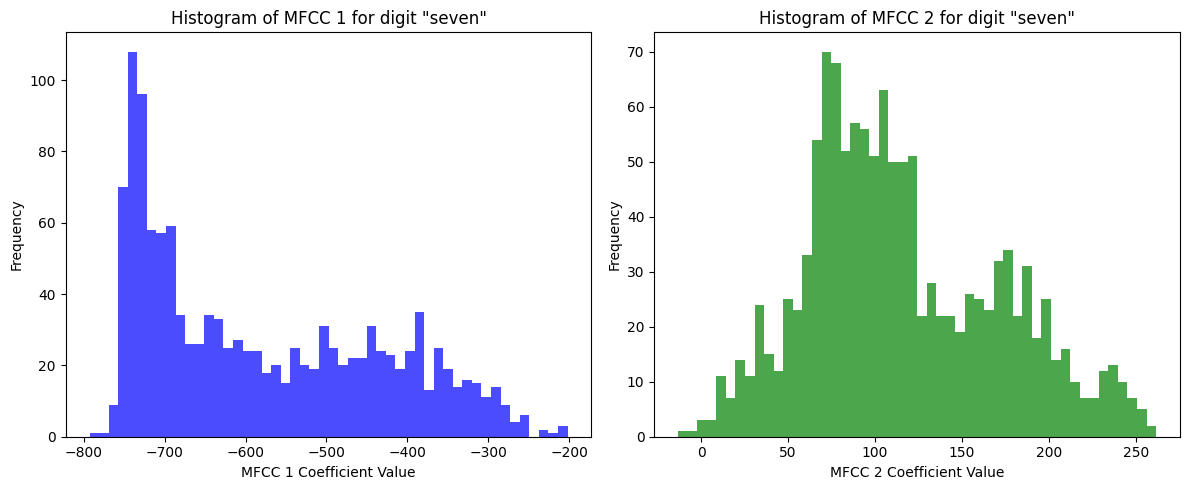

Digit "seven":
Variance of MFCC 1: 21497.80
Variance of MFCC 2: 3068.08



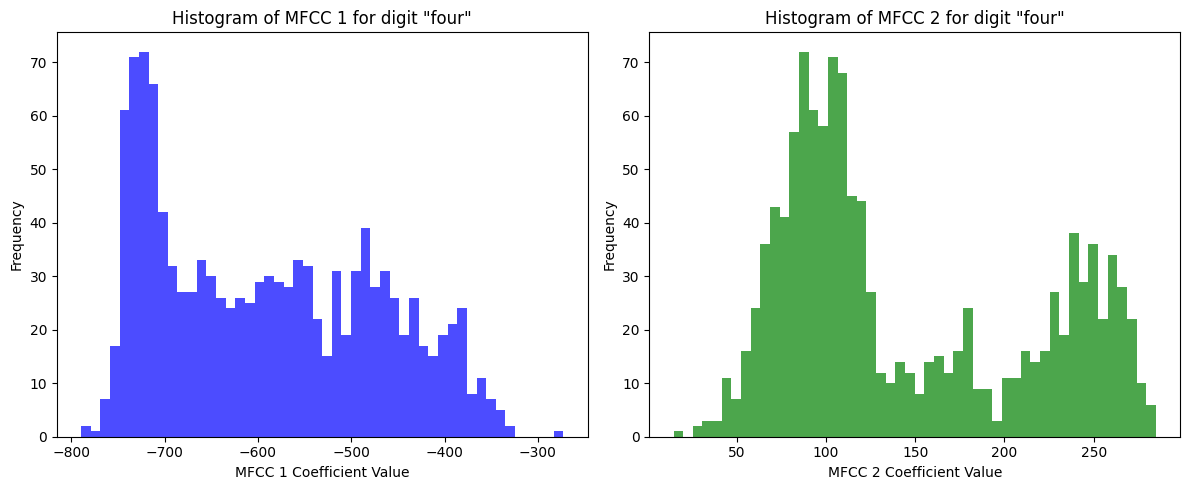

Digit "four":
Variance of MFCC 1: 14009.79
Variance of MFCC 2: 4906.44



In [4]:
'''
Αναπαραστήστε τα ιστογράμματα του 1ου και του 2ου MFCC των ψηφίων n1 (7) και n2 (4) για όλες τους τις
εκφωνήσεις. Πόση απόκλιση υπάρχει?
'''

import librosa
import numpy as np

#from step2 import data_parser
#from step3 import extract_mfccs
import matplotlib.pyplot as plt

# Step 2: Load data
wavs, speakers, digit_labels = data_parser('./data/digits/')

# Step 3: Extract MFCCs
mfccs_list = extract_mfccs(wavs)

# Digits to analyze
digits_to_analyze = ['seven', 'four']

# Collect MFCC coefficients for each digit
digit_mfccs = {digit: {'mfcc1': [], 'mfcc2': []} for digit in digits_to_analyze}

for idx, digit in enumerate(digit_labels):
    if digit in digits_to_analyze:
        mfcc, delta, delta2 = mfccs_list[idx]
        # Collect the 1st and 2nd MFCC coefficients across all frames
        digit_mfccs[digit]['mfcc1'].extend(mfcc[0].flatten())
        digit_mfccs[digit]['mfcc2'].extend(mfcc[1].flatten())

# Plot histograms
for digit in digits_to_analyze:
    mfcc1_values = np.array(digit_mfccs[digit]['mfcc1'])
    mfcc2_values = np.array(digit_mfccs[digit]['mfcc2'])

    plt.figure(figsize=(12, 5))

    # Histogram for MFCC 1
    plt.subplot(1, 2, 1)
    plt.hist(mfcc1_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of MFCC 1 for digit "{digit}"')
    plt.xlabel('MFCC 1 Coefficient Value')
    plt.ylabel('Frequency')

    # Histogram for MFCC 2
    plt.subplot(1, 2, 2)
    plt.hist(mfcc2_values, bins=50, color='green', alpha=0.7)
    plt.title(f'Histogram of MFCC 2 for digit "{digit}"')
    plt.xlabel('MFCC 2 Coefficient Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Calculate and print variance
    variance_mfcc1 = np.var(mfcc1_values)
    variance_mfcc2 = np.var(mfcc2_values)
    print(f'Digit "{digit}":')
    print(f'Variance of MFCC 1: {variance_mfcc1:.2f}')
    print(f'Variance of MFCC 2: {variance_mfcc2:.2f}\n')

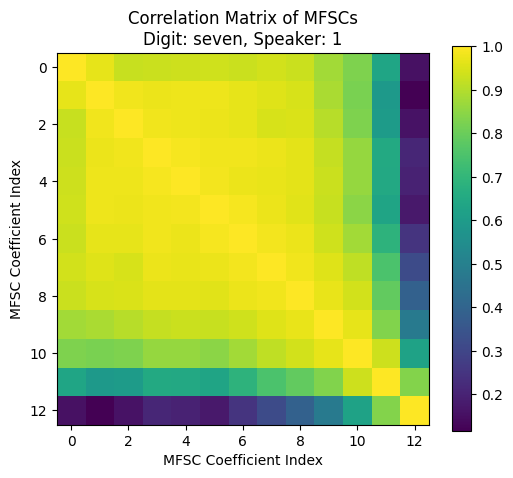

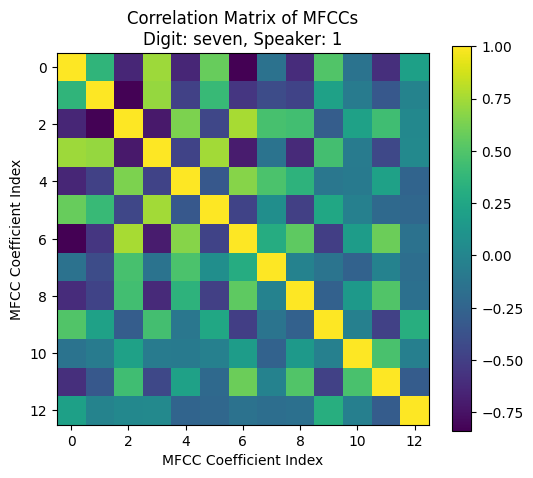

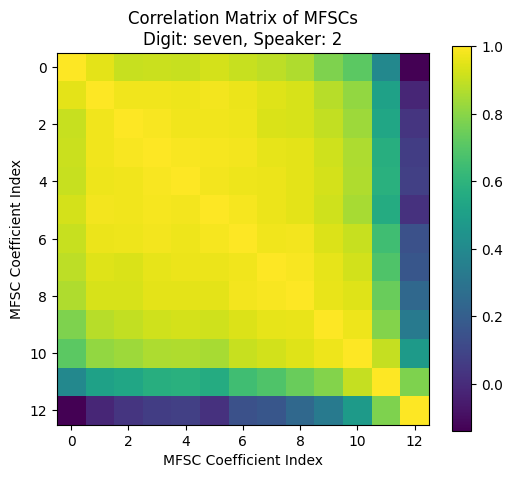

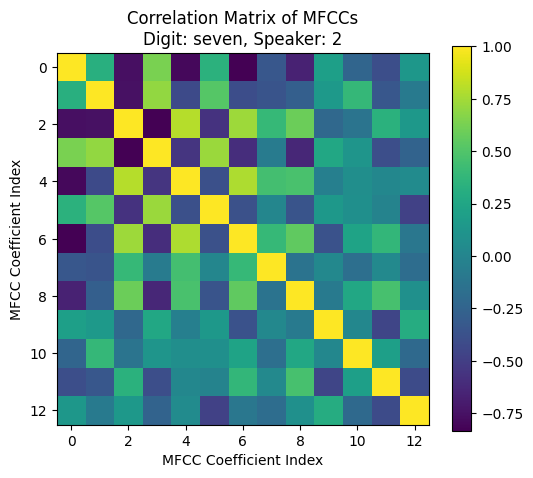

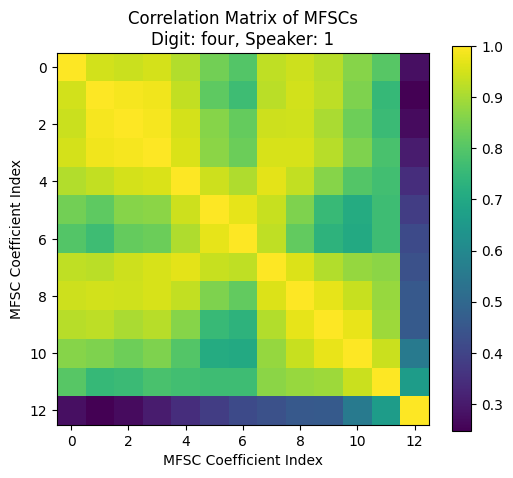

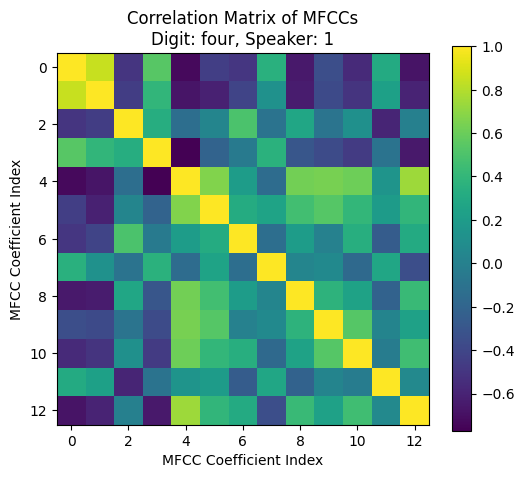

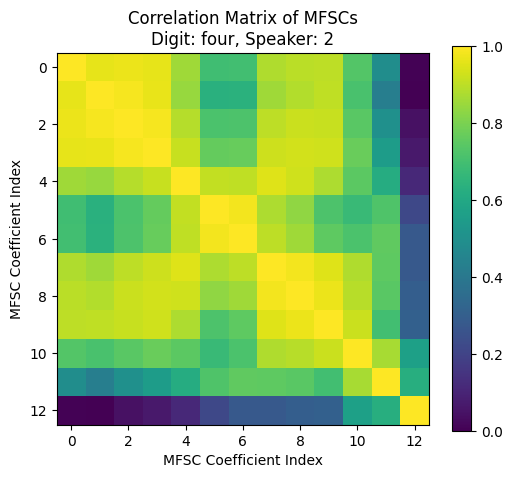

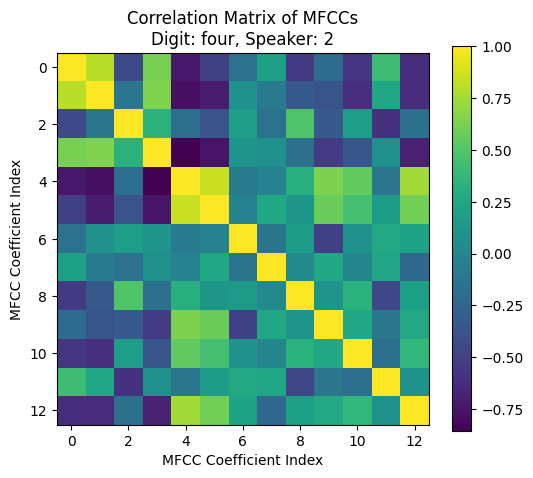

In [5]:
# Build a mapping from (digit, speaker) to index
utterances = {}

for idx, (digit, speaker) in enumerate(zip(digit_labels, speakers)):
    key = (digit, speaker)
    if key not in utterances:
        utterances[key] = idx

# Select indices for 'seven' and 'four' spoken by speakers 1 and 2
selected_indices = [
    utterances.get(('seven', 1)),
    utterances.get(('seven', 2)),
    utterances.get(('four', 1)),
    utterances.get(('four', 2))
]

def process_utterance(wav):
    # Compute MFSCs (log Mel spectrogram)
    S = librosa.feature.melspectrogram(
        y=wav,
        sr=16000,
        n_fft=int(0.025 * 16000),    # 25 ms window
        hop_length=int(0.010 * 16000), # 10 ms hop
        n_mels=13
    )
    log_S = librosa.power_to_db(S)

    # Compute MFCCs from the log Mel spectrogram
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    return log_S, mfcc

# Process each selected utterance
for idx in selected_indices:
    if idx is not None:
        wav = wavs[idx]
        digit = digit_labels[idx]
        speaker = speakers[idx]

        # Extract MFSCs and MFCCs
        mfsc, mfcc = process_utterance(wav)

        # Compute correlation matrices
        corr_mfsc = np.corrcoef(mfsc)
        corr_mfcc = np.corrcoef(mfcc)

        # Plot correlation matrix for MFSCs
        plt.figure(figsize=(6, 5))
        plt.imshow(corr_mfsc, cmap='viridis', interpolation='nearest')
        plt.title(f'Correlation Matrix of MFSCs\nDigit: {digit}, Speaker: {speaker}')
        plt.colorbar()
        plt.xlabel('MFSC Coefficient Index')
        plt.ylabel('MFSC Coefficient Index')
        plt.show()

        # Plot correlation matrix for MFCCs
        plt.figure(figsize=(6, 5))
        plt.imshow(corr_mfcc, cmap='viridis', interpolation='nearest')
        plt.title(f'Correlation Matrix of MFCCs\nDigit: {digit}, Speaker: {speaker}')
        plt.colorbar()
        plt.xlabel('MFCC Coefficient Index')
        plt.ylabel('MFCC Coefficient Index')
        plt.show()
    else:
        print('Selected index not found.')
